# CSC424 - Neural Networks - Assignment 5

<br>

### Team - Random Access Memories
> #### Rivu Bhattacharjee — 1910626
> #### Ahnaf Abdullah — 2130223
> #### Tausia Tahsin Nuzum — 2221415




## Assignment 5A

#### Problem Statement
1. 	In this assignment, we will develop a LSTM  based language model that will suggest the rest of the sentence for given partial input sentence.

2. 	The idea is to simulate Google's suggestions when we try to search.

3. 	For example: if you input “I eat”, output suggestion will be “rice in a restaurant”. The suggestion would be based on the training with hundreds of English sentences found here.  

4. 	Please note that though this dataset is supplied for emotion recognition as downstream task, we can use the sentences for our next word prediction by removing label of the sentence. So remove the last column (the emotion label)from your train, validation, and test set. Now you can use the train set to train  your model for next word prediction.

5. 	Your maximum sentence length is 20  words. So in this model, you will use 20  LSTM   to capture the recurrence.  Word2vec    word embedding would be used for input to the LSTM cells.
6. 	During the training, if the sentence is less than 20 words, you will use EOL to fill up the sentence. EOL will have a unique one hot encoding. If any sentence is more than 20 words long, you will trim the sentence.
7.	So training with this language model will help the model learn the word sequences in next word prediction setting.

    a.	At first, read all sentences from the given dataset, clip them in to 20  word sentences. Add EOL if necessary. Get the word2vec embeddings for all the unique words. Split the Train, validation, and test dataset

    b.	Build the language model with LSTM cell for 20  recurrences. Use the lstm cell from pytorch library to build your lstm based language model

    c.	Use the sentences for training by following the next word prediction setting.

    d.	Example of training sentences would be supplied to the language model as follows:

```
        i.	Input: I drink tea eol eol eol eol eol … eol, Output: drink tea eol eol eol eol…..eol
        ii.	Input: Bangladesh has been playing cricket since 2000 eol, eol ….. eol, Output:  has been playing cricket since 2000 eol, eol ….. eol,
        iii.	Input: I drink coffee in café eol eol eol ….. eol. Output:  drink coffee in café eol eol eol ….. eol
```

8.	During the training, cross entropy loss will be applied.

9.	After training, take test data (make partial sentences) and predict the rest of the sentences. Calculate the prediction accuracy with the ground truth.


#### Setup

In [ ]:
### IMPORTS
import torch
import torchvision.transforms as transforms
import kagglehub       # Load the dataset
import pathlib         #
from tqdm.notebook import tqdm
from gensim.models import Word2Vec
from torch.utils.data import DataLoader, Dataset
import os

### CONSTANTS
WORD_VEC_SIZE = 296         # size of the vectors to be used as word embeddings
MAX_LEN = 20                  # number of words to generate
batch_size = 64           # Hyperparameter, constant for now


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Define device (CPU or GPU)
# try:
#     device = torch_directml.device()
# except:
#     pass
# print("Device used:", device)

In [ ]:
### HELPER METHODS
class Helpers:

    @staticmethod
    def getvocab(sentences: list):
        vocab = set(word for s in sentences for word in s)

        return vocab

    @staticmethod
    def __process_rawtextfile_into_sentences(path: str):
            f = open(path, "r")
            rawtext = f.read().split('\n')
            ret = []

            for sentence in rawtext:
                if sentence != '':
                    sentence = sentence.split(';')[0]
                    ret.append(sentence)

            f.close()
            return ret

    @staticmethod
    def __preprocess_sentences(raw_sentences):
            processed = []
            count = 0
            trim_affected = 0
            for sentence in raw_sentences:
                count += 1
                words = sentence.strip().split()
                if len(words) > 20:   # Trim if longer than 20 words
                    words = words[:20]
                    trim_affected += 1

                #while len(words) < 20:    # Add EOL tokens if shorter than 20 words
                    #words.append('EOL')
                processed.append(words)
            return processed#, trim_affected/count

    @staticmethod
    def produce_rawdataset(path:str):
        sentences = Helpers.__process_rawtextfile_into_sentences(path)
        sentences = Helpers.__preprocess_sentences(sentences)    # 38.5% of test sentences are affected by trimming, this will negatively affect the quality of the output

        return sentences


In [ ]:
# Transformations: Convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the dataset
pth = pathlib.Path(kagglehub.dataset_download("praveengovi/emotions-dataset-for-nlp"))
print("Raw text files at:", pth)

# Process text files into list of tokenized sentences
train_sentences = Helpers.produce_rawdataset(pth.joinpath('train.txt'))
val_sentences = Helpers.produce_rawdataset(pth.joinpath('val.txt'))
test_sentences = Helpers.produce_rawdataset(pth.joinpath('test.txt'))

# Display dataset example
print(train_sentences[0])



100%|██████████| 721k/721k [00:00<00:00, 67.4MB/s]

Extracting files...
Raw text files at: /root/.cache/kagglehub/datasets/praveengovi/emotions-dataset-for-nlp/versions/1


['i', 'didnt', 'feel', 'humiliated']


In [ ]:
### DATALOADER
class SentencePredictionDataset(Dataset):
    def __init__(self, file, word_to_idx, max_len=20, sentences_list: list=None, context_guess=5, smallest_input_prediction=1):
        self.data = []

        if file is not None:
            sentences = Helpers.produce_rawdataset(file)
        else:
            if sentences_list is None:
                raise Exception("Both file and list should not be none!")
            sentences = sentences_list


        # as-is sentences, only shifted by 1, no predictions are actually happening here! (because the shifting happens after padding)
        for sentence in sentences:
            # Convert words to indices
            indices = [word_to_idx.get(word, word_to_idx['UNK']) for word in sentence]

            # Pad with EOL tokens
            while len(indices) <= max_len:
                indices.append(word_to_idx['EOL'])

            # Create input (full sequence) and target (shifted sequence)
            input_seq = indices[:-1]  # All words except last
            target_seq = indices[1:]  # All words except first

            # maybe append more sequences than something that only predicts one word? maybe predict like 2/3/4/5 words?
            self.data.append((input_seq, target_seq))

        # input has last i words missing, predict next i words correctly
        for i in range(2, context_guess):
            for sentence in sentences:
                # Convert words to indices
                indices = [word_to_idx.get(word, word_to_idx['UNK']) for word in sentence]

                # Create input (full sequence) and target (shifted sequence)
                input_seq = indices[:-i]  # All words except last
                if len(input_seq) <= smallest_input_prediction:
                    continue     # avoid difficult tests (how do you expect someone to autocomplete 'i feel fine' from 'i' or '' [empty string])
                target_seq = indices[1:]  # All words except first

                # Pad with EOL tokens
                while len(input_seq) < max_len:
                    input_seq.append(word_to_idx['EOL'])
                while len(target_seq) < max_len:
                    target_seq.append(word_to_idx['EOL'])

                # maybe append more sequences than something that only predicts one word? maybe predict like 2/3/4/5 words?
                self.data.append((input_seq, target_seq))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_seq, target_seq = self.data[idx]
        return torch.tensor(input_seq), torch.tensor(target_seq)

#### Construct Word Embeddings and Word IDs

In [ ]:
# Produce word embeddings that contain positional and contextual/semantic information about the language by training a model using our dataset and have it produce vectors that represent each word in our dataset

print("Producing word2vec model")
# to produce an embedding, we must teach it the semantics of the language by giving it our dataset first
print(train_sentences[0])
embedding_model = Word2Vec(train_sentences+val_sentences,
                    vector_size=WORD_VEC_SIZE,
                    window=5,  # Context window size
                    min_count=1,  # Include all words, even rare ones
                    workers=os.cpu_count())  # Number of CPU threads to use
print("Defined")

Producing word2vec model
['i', 'didnt', 'feel', 'humiliated']
Defined


In [ ]:
def generate_word_to_idx(v, id_file_location: pathlib.Path):

    def make_dictionary(v: set):
        v = v.union(['EOL', 'UNK'])    # special command tokens
        d = {word: idx for idx, word in enumerate(v)}
        return d

    # avoid changing word-id mappings every time we run the program
    if (id_file_location.is_file()):
        f = open(id_file_location, 'rb')
        word_to_idx = torch.load(f)

        different = False
        for word in v:
            if word not in word_to_idx.keys():
                different = True

        if (different):   # check if dataset changed to have new words, etc
            print("""Vocab seems to have changed, probably because the dataset changed... renewing
                IDs and disregarding id file, {}-idfile vs {}-dataset""".format(len(word_to_idx), len(v)))
            word_to_idx = make_dictionary(v)
    else: # doesn't exist, create
                # needed cause vocab is a set(fast), and the elements in it are unordered
        word_to_idx = make_dictionary(v)

    # write mappings to file
    import os
    os.makedirs(os.path.dirname(id_file_location), exist_ok=True)
    torch.save(word_to_idx, open(id_file_location, 'wb'))
    return word_to_idx

vocab = Helpers.getvocab(train_sentences + val_sentences)
word_to_idx = generate_word_to_idx(vocab, pathlib.Path('data/SentencePredictionDataset/vocab_id.dat'))
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
print(len(vocab), "unique words")

13585 unique words


In [ ]:
def create_embedding_dict(word2vec_model, vocabulary):
    """
    Creates a dictionary mapping each word to its vector representation
    Also handles the special EOL token
    """
    embedding_dim = word2vec_model.vector_size
    word_to_vec = {}
    not_in_wv = 0

    for word in vocabulary:
        if word in word2vec_model.wv:
            word_to_vec[word] = word2vec_model.wv[word]
        else:
            # For unknown words set a random vector (word2vec uses numpy arrays)
            #print("Does this really happen?")
            not_in_wv += 1
            word_to_vec[word] = torch.rand(embedding_dim).numpy()

    # Add EOL token if not already in vocabulary
    if 'EOL' not in word_to_vec:
        word_to_vec['EOL'] = torch.rand(embedding_dim).numpy()

    if 'UNK' not in word_to_vec:
        word_to_vec['UNK'] = torch.rand(embedding_dim).numpy()

    print("{} words not learned by the word2vec model, were assigned random vectors".format(not_in_wv))
    return word_to_vec

embedding = create_embedding_dict(embedding_model, vocab)

0 words not learned by the word2vec model, were assigned random vectors


#### Model Definition

In [ ]:
import torch.nn as nn
class LSTM_20(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, word_to_vec):
        super().__init__()

        self.hidden_dim = hidden_dim

        # Create embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Dropout on words
        self.dropout = nn.Dropout(0.4)

        # initialize embedding layer with embeddings from word2vec
        embedding_weights = torch.zeros([vocab_size, embedding_dim])
        for idx, word in idx_to_word.items():
            embedding_weights[idx] = torch.tensor(word_to_vec[word])
        self.embedding.weight = nn.Parameter(embedding_weights)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True, dropout=0.4) # not sure if num_layers should be 20
        self.fc = nn.Linear(hidden_dim, vocab_size)

        # init weights
        torch.nn.init.xavier_uniform_(self.fc.weight)


    def forward(self, x, hidden=None):
        # x.shape : (batch_size, sequence_length)
        #print(x.shape)
        x = self.embedding(x)#;print(x.shape)
        x, _ = self.lstm(x)#;print(x.shape)
        x = self.dropout(x)
        # Shape: (batch_size, sequence_length, hidden_dim)
        x = self.fc(x)#;print(x.shape) # Shape: (batch_size, sequence_length, vocab_size)
        return x


In [ ]:
model = LSTM_20(len(word_to_idx), WORD_VEC_SIZE, 128, embedding).to(DEVICE)
# optimizer = torch.optim.RMSprop(
#         model.parameters(),
#         lr=0.01,
#         alpha=0.99
#     )
# optimizer = torch.optim.SGD(
#     model.parameters(),
#     lr = 0.01,
# )
optimizer = torch.optim.Adagrad(
    model.parameters(),
    lr=0.01
)
criterion = nn.CrossEntropyLoss()
print(len(vocab), len(embedding), len(word_to_idx))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


13585 13587 13587


In [ ]:
train_loader = DataLoader(SentencePredictionDataset(None, word_to_idx, MAX_LEN, sentences_list=train_sentences, context_guess=3), batch_size, shuffle=True)
val_loader = DataLoader(SentencePredictionDataset(None, word_to_idx, MAX_LEN, sentences_list=val_sentences, context_guess=3), batch_size, shuffle=True)
test_loader = DataLoader(SentencePredictionDataset(None, word_to_idx, MAX_LEN, sentences_list=test_sentences, context_guess=1), batch_size, shuffle=True)


print("Sentences (Train):", len(train_sentences))
print("Sentences (Validation):", len(val_sentences))
print("Sentences (Test):", len(test_sentences))
print("DataLoader sentences (Train):", len(train_loader)*batch_size)
print("DataLoader sentences (Validation):", len(val_loader)*batch_size)
print("DataLoader sentences (Test):", len(test_loader)*batch_size)

SentencePredictionDataset(None, word_to_idx, MAX_LEN, sentences_list=train_sentences)[0]

Sentences (Train): 16000
Sentences (Validation): 2000
Sentences (Test): 2000
DataLoader sentences (Train): 32000
DataLoader sentences (Validation): 4032
DataLoader sentences (Test): 2048


(tensor([2051, 9626, 1500, 1707, 3923, 3923, 3923, 3923, 3923, 3923, 3923, 3923,
         3923, 3923, 3923, 3923, 3923, 3923, 3923, 3923]),
 tensor([9626, 1500, 1707, 3923, 3923, 3923, 3923, 3923, 3923, 3923, 3923, 3923,
         3923, 3923, 3923, 3923, 3923, 3923, 3923, 3923]))

In [ ]:
def train(epochs, model):
    train_losses, val_losses, accuracy = [], [], []

    epoch_loop = tqdm(range(epochs), desc="Epoch")
    for epoch in epoch_loop:
        # Training
        hidden = None
        with tqdm(total=len(train_loader), desc="Training: ", leave=False) as train_loop:
            model.train()
            total_loss = 0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                optimizer.zero_grad()
                model.zero_grad()
                outputs = model(inputs)

                # Reshape for loss calculation
                batch_size = outputs.size(0)
                #print(outputs.shape)      # B, (max_len-1), len(vocab) rank 3 tensor    ## each batch, has max_len-1 words, and at each word is the probability(logits) vector
                outputs = outputs.view(batch_size * (MAX_LEN), -1)  # -1 because we predict next word
                #print(outputs.shape)      # B * (max_len-1), len(vocab) matrix

                # print(targets.shape)      # B, (max_len-1) matrix                      ## each batch, has max_len-1 words, and contains the correct word embedding vector for that word
                targets = targets.view(-1)
                #print(targets.shape)        # B * (max_len-1), len(vocab) vector         # each element contains the id of

                loss = criterion(outputs, targets)
                loss.backward()     ## retain_graph=True ## NO way we dont wanna backpropagate all the way to the beginning each time
                optimizer.step()

                total_loss += loss.item()

                # detach backprop from hidden
                #print(hidden)
                train_loop.update(1)

            train_losses.append(total_loss / len(train_loader))

        # Validation
        with tqdm(total=len(val_loader), desc="Testing: ", leave=False) as test_loop:
            model.eval()
            total_loss = 0
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                    outputs = model(inputs)  # B * 20 * len(vocab)

                    # Calculate loss
                    outputs_flat = outputs.view(-1, outputs.size(2))
                    #print(outputs_flat.shape)
                    targets_flat = targets.view(-1)
                    loss = criterion(outputs_flat, targets_flat)
                    total_loss += loss.item()

                    # Calculate accuracy
                    _, predicted = outputs.max(2)
                    #print(predicted)
                    mask = targets != word_to_idx['EOL']  # Don't count EOL tokens
                    correct += (predicted == targets)[mask].sum().item()
                    #print(correct)
                    total += mask.sum().item()

                    test_loop.update(1)

            val_losses.append(total_loss / len(val_loader))
            accuracy.append(100 * correct / total)

        epoch_loop.set_postfix_str(f"Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Accuracy: {accuracy[-1]:.4f}%")

    return train_losses, val_losses, accuracy


train_loss, val_loss, acc = train(30, model)
#tl2, vl2, ac2 = train(100)
# print(train(model, train_loader, max_len=MAX_LEN))
# print(train(model, train_loader, max_len=MAX_LEN))
# print(train(model, train_loader, max_len=MAX_LEN))


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

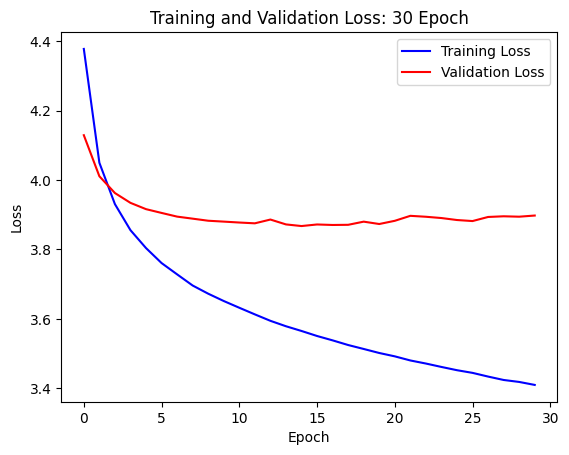

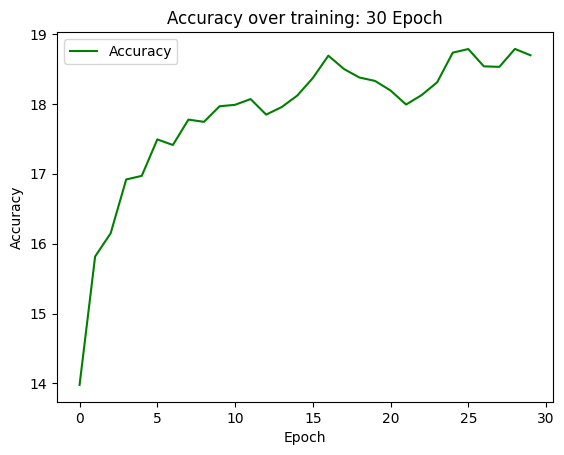

In [ ]:
# Improvements:
# Add multiple types of prediction, like removing last word and second last word

# Added dropout layer, this causes the accuracy to fall less (as the model is forced to generalize)

# Hidden Dims 1000->256

# Plot the training and validation losses
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss, label="Training Loss", color="blue")
plt.plot(range(len(train_loss)), val_loss, label="Validation Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss: 30 Epoch")
plt.legend()
plt.show()


plt.plot(range(len(train_loss)), acc, label="Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over training: 30 Epoch")
plt.legend()
plt.show()

#### Experimentation: Finding best optimizer


##### Adagrad

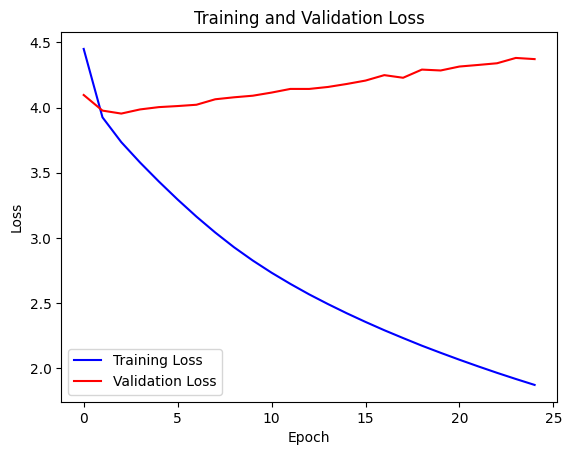

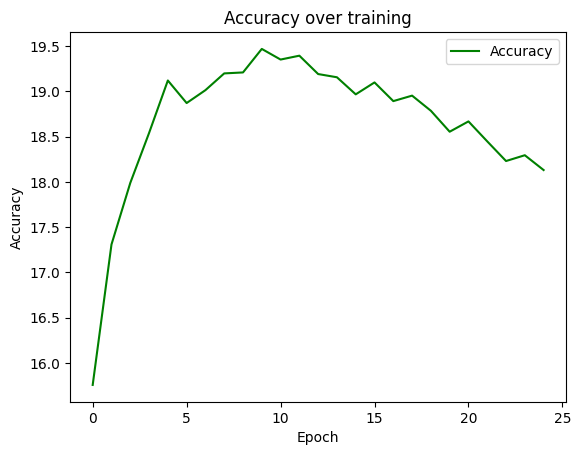

In [ ]:
# train_loss = train_loss +tl2
# val_loss = val_loss + vl2
# acc = acc + ac2
# Plot the training and validation losses
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss, label="Training Loss", color="blue")
plt.plot(range(len(train_loss)), val_loss, label="Validation Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


plt.plot(range(len(train_loss)), acc, label="Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over training")
plt.legend()
plt.show()

In [ ]:
correct = test_sentences[0]
testing = correct[:10]      # autocomplete based on

input_test = [word_to_idx[i] for i in testing]
while len(input_test) < 20:
  input_test.append(word_to_idx['EOL'])

print("Input:", [idx_to_word[i] for i in input_test])
print("Converted to IDs:", input_test)
output = model(torch.tensor(input_test).to(DEVICE))
print("Output: ", torch.argmax(output, dim=1).tolist())
print("Converted to words", [idx_to_word[i] for i in torch.argmax(output, dim=1).tolist()])

Input: ['im', 'feeling', 'rather', 'rotten', 'so', 'im', 'not', 'very', 'ambitious', 'right', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Converted to IDs: [10176, 4151, 7924, 4998, 6664, 10176, 4114, 10378, 10563, 3400, 6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619]
Output:  [4151, 966, 9955, 6619, 11726, 6029, 6029, 849, 6619, 6596, 6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619]
Converted to words ['feeling', 'a', 'mellow', 'EOL', 'i', 'going', 'going', 'sure', 'EOL', 'now', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']


##### SGD

It's said to be good for sparse gradients, but we observed no good results, accuracy was horrible

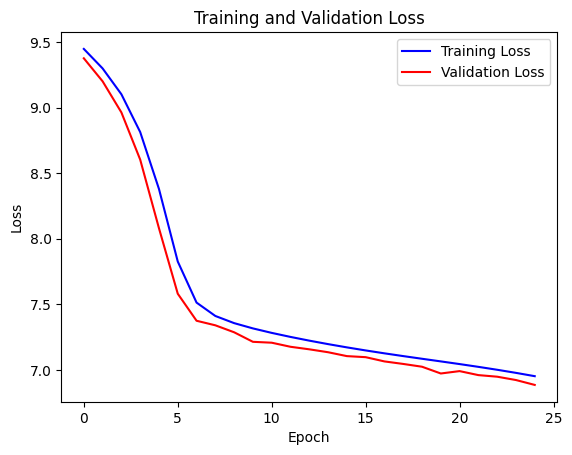

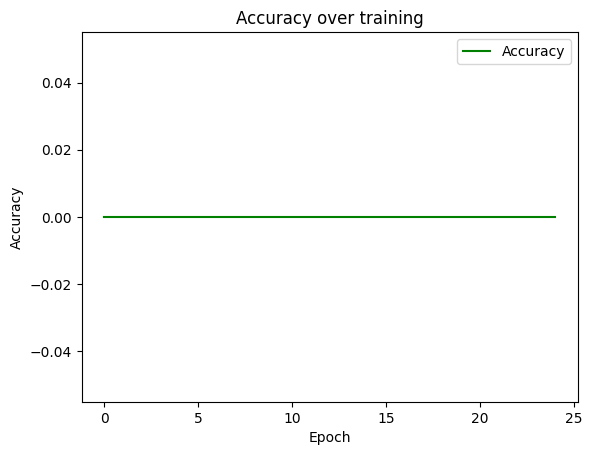

In [ ]:
# train_loss = train_loss +tl2
# val_loss = val_loss + vl2
# acc = acc + ac2
# Plot the training and validation losses
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss, label="Training Loss", color="blue")
plt.plot(range(len(train_loss)), val_loss, label="Validation Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


plt.plot(range(len(train_loss)), acc, label="Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over training")
plt.legend()
plt.show()

In [ ]:
correct = test_sentences[0]
testing = correct[:10]      # autocomplete based on

input_test = [word_to_idx[i] for i in testing]
while len(input_test) < 20:
  input_test.append(word_to_idx['EOL'])

print("Input:", [idx_to_word[i] for i in input_test])
print("Converted to IDs:", input_test)
output = model(torch.tensor(input_test).to(DEVICE))
print("Output: ", torch.argmax(output, dim=1).tolist())
print("Converted to words", [idx_to_word[i] for i in torch.argmax(output, dim=1).tolist()])

Input: ['im', 'feeling', 'rather', 'rotten', 'so', 'im', 'not', 'very', 'ambitious', 'right', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Converted to IDs: [10176, 4151, 7924, 4998, 6664, 10176, 4114, 10378, 10563, 3400, 6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619]
Output:  [6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619, 6619]
Converted to words ['EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']


#### Test


In [ ]:
correct = test_sentences[216]
testing = correct[:8]      # autocomplete based on

input_test = [word_to_idx.get(i, word_to_idx['UNK']) for i in testing]
while len(input_test) < 20:
  input_test.append(word_to_idx['EOL'])

print("Original/Correct:", correct)
print("Input:", [idx_to_word[i] for i in input_test])
print("Converted to IDs:", input_test)
output = model(torch.tensor(input_test).to(DEVICE))
print()
print("Output: ", torch.argmax(output, dim=1).tolist())
print("Converted to words", [idx_to_word[i] for i in torch.argmax(output, dim=1).tolist()])

Original/Correct: ['i', 'sat', 'there', 'cold', 'i', 'flashed', 'back', 'to', 'going', 'to', 'the', 'hockey', 'city', 'classic', 'and', 'the', 'degree', 'weather', 'and', 'it']
Input: ['i', 'sat', 'there', 'cold', 'i', 'UNK', 'back', 'to', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Converted to IDs: [2051, 5455, 9185, 7875, 2051, 43, 3825, 8095, 3923, 3923, 3923, 3923, 3923, 3923, 3923, 3923, 3923, 3923, 3923, 3923]

Output:  [1500, 10504, 7453, 7453, 1500, 7453, 3923, 1500, 3923, 3923, 3923, 3923, 3923, 3923, 3923, 3923, 3923, 3923, 3923, 3923]
Converted to words ['feel', 'on', 'and', 'and', 'feel', 'and', 'EOL', 'feel', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']


In [ ]:
def test():
    with tqdm(total=len(test_loader), desc="Testing: ") as test_loop:
        model.eval()
        total_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)

                # Calculate loss
                outputs_flat = outputs.view(-1, outputs.size(2))
                #print(outputs_flat.shape)
                targets_flat = targets.view(-1)
                loss = criterion(outputs_flat, targets_flat)
                total_loss += loss.item()

                # Calculate accuracy
                _, predicted = outputs.max(2)
                #print(predicted)
                mask = targets != word_to_idx['EOL']  # Don't count EOL tokens
                correct += (predicted == targets)[mask].sum().item()
                #print(correct)
                total += mask.sum().item()

                test_loop.update(1)

        test_loss = total_loss / len(test_loader)
        accuracy = 100 * correct / total

    return test_loss, accuracy

test_loss, acc = test()
print("Current Test Loss with Last Word Prediction:", test_loss)
print("Accuracy:", acc, "%")

Testing:   0%|          | 0/32 [00:00<?, ?it/s]

Current Test Loss with Last Word Prediction: 4.0235535353422165
Accuracy: 17.737176980769913 %


According to our results, we observed the best performance after training for 15 epochs. We retrain the model and save all required parameters for 5C.



In [ ]:
import pickle

model = LSTM_20(len(word_to_idx), WORD_VEC_SIZE, 128, embedding).to(DEVICE)
optimizer = torch.optim.Adagrad(
    model.parameters(),
    lr=0.01
)
criterion = nn.CrossEntropyLoss()
train(15, model)


Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

([4.356081982135772,
  4.023234259605408,
  3.9107254567146303,
  3.8380356554985045,
  3.786441922187805,
  3.745298710346222,
  3.7126554641723635,
  3.684327627658844,
  3.658669385433197,
  3.6367401394844054,
  3.6170973386764524,
  3.599405619621277,
  3.581030264854431,
  3.5666392827033997,
  3.5509681944847107],
 [4.101366099857149,
  3.9974521568843295,
  3.9430417068420893,
  3.9158693419562445,
  3.9028775616297646,
  3.888156815180703,
  3.876338758165874,
  3.8693643865131198,
  3.866515659150623,
  3.8629420446971108,
  3.8569121020180837,
  3.857051785030062,
  3.863409159675477,
  3.8607718036288308,
  3.8606854204147583],
 [14.596577452499243,
  15.903627330519793,
  16.44496678953648,
  16.989867692362484,
  17.1857471018751,
  17.520522819951207,
  17.821464821838774,
  17.737770892319748,
  17.76448172088965,
  18.1419947646776,
  18.15267909610556,
  18.1508983742009,
  17.862421425645955,
  18.074327332300516,
  18.302259736097014])

In [ ]:
# SAVE
with open('lstm_20_modelprereqs.pickle', 'wb') as handle:
   a = (embedding, word_to_idx)
   pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

torch.save(model, open('lstm_20_weights.pt', 'wb'))

In [ ]:
#LOAD
e, w = pickle.load(open('lstm_20_modelprereqs.pickle', 'rb'))

model = torch.load(open('lstm_20_weights.pt', 'rb'))
test_loss, acc = test()
print("Testing model after import from file, Loss:", test_loss)
print("Accuracy:", acc, "%")

FileNotFoundError: [Errno 2] No such file or directory: 'lstm_20_modelprereqs.pickle'

## Assignment 5B

#### Problem Statement
1. 	Redo the assignment 5A with transformers with sentence length 20 with the exact same training and test setting. Use the transformer model from pytorch library with 8 attention head. You don’t need to implement transformer model as it has been already implemented in the pytorch library. But don’t use the pretrained weights.
2.	Compare the performance with LSTM based language model


#### Setup

In [ ]:
### IMPORTS
import torch
import torchvision.transforms as transforms
import kagglehub       # Load the dataset
import pathlib         #
from tqdm.notebook import tqdm
from gensim.models import Word2Vec
from torch.utils.data import DataLoader, Dataset
import os

### CONSTANTS
WORD_VEC_SIZE = 296         # size of the vectors to be used as word embeddings
MAX_LEN = 20                  # number of words to generate
batch_size = 64           # Hyperparameter, constant for now


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Define device (CPU or GPU)
# try:
#     device = torch_directml.device()
# except:
#     pass
# print("Device used:", device)

In [ ]:
### HELPER METHODS
class Helpers:

    @staticmethod
    def getvocab(sentences: list):
        vocab = set(word for s in sentences for word in s)

        return vocab

    @staticmethod
    def __process_rawtextfile_into_sentences(path: str):
            f = open(path, "r")
            rawtext = f.read().split('\n')
            ret = []

            for sentence in rawtext:
                if sentence != '':
                    sentence = sentence.split(';')[0]
                    ret.append(sentence)

            f.close()
            return ret

    @staticmethod
    def __preprocess_sentences(raw_sentences):
            processed = []
            count = 0
            trim_affected = 0
            for sentence in raw_sentences:
                count += 1
                words = sentence.strip().split()
                if len(words) > 20:   # Trim if longer than 20 words
                    words = words[:20]
                    trim_affected += 1

                #while len(words) < 20:    # Add EOL tokens if shorter than 20 words
                    #words.append('EOL')
                processed.append(words)
            return processed#, trim_affected/count

    @staticmethod
    def produce_rawdataset(path:str):
        sentences = Helpers.__process_rawtextfile_into_sentences(path)
        sentences = Helpers.__preprocess_sentences(sentences)    # 38.5% of test sentences are affected by trimming, this will negatively affect the quality of the output

        return sentences


In [ ]:
# Transformations: Convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the dataset
pth = pathlib.Path(kagglehub.dataset_download("praveengovi/emotions-dataset-for-nlp"))
print("Raw text files at:", pth)

# Process text files into list of tokenized sentences
train_sentences = Helpers.produce_rawdataset(pth.joinpath('train.txt'))
val_sentences = Helpers.produce_rawdataset(pth.joinpath('val.txt'))
test_sentences = Helpers.produce_rawdataset(pth.joinpath('test.txt'))

# Display dataset example
print(train_sentences[0])



100%|██████████| 721k/721k [00:00<00:00, 836kB/s]

Extracting files...


Raw text files at: /root/.cache/kagglehub/datasets/praveengovi/emotions-dataset-for-nlp/versions/1
['i', 'didnt', 'feel', 'humiliated']


In [ ]:
### DATALOADER
class SentencePredictionDataset(Dataset):
    def __init__(self, file, word_to_idx, max_len=20, sentences_list: list=None, context_guess=5, smallest_input_prediction=1):
        self.data = []

        if file is not None:
            sentences = Helpers.produce_rawdataset(file)
        else:
            if sentences_list is None:
                raise Exception("Both file and list should not be none!")
            sentences = sentences_list


        # as-is sentences, only shifted by 1, no predictions are actually happening here! (because the shifting happens after padding)
        for sentence in sentences:
            # Convert words to indices
            indices = [word_to_idx.get(word, word_to_idx['UNK']) for word in sentence]

            # Pad with EOL tokens
            while len(indices) <= max_len:
                indices.append(word_to_idx['EOL'])

            # Create input (full sequence) and target (shifted sequence)
            input_seq = indices[:-1]  # All words except last
            target_seq = indices[1:]  # All words except first

            # maybe append more sequences than something that only predicts one word? maybe predict like 2/3/4/5 words?
            self.data.append((input_seq, target_seq))

        # input has last i words missing, predict next i words correctly
        for i in range(2, context_guess):
            for sentence in sentences:
                # Convert words to indices
                indices = [word_to_idx.get(word, word_to_idx['UNK']) for word in sentence]

                # Create input (full sequence) and target (shifted sequence)
                input_seq = indices[:-i]  # All words except last
                if len(input_seq) <= smallest_input_prediction:
                    continue     # avoid difficult tests (how do you expect someone to autocomplete 'i feel fine' from 'i' or '' [empty string])
                target_seq = indices[1:]  # All words except first

                # Pad with EOL tokens
                while len(input_seq) < max_len:
                    input_seq.append(word_to_idx['EOL'])
                while len(target_seq) < max_len:
                    target_seq.append(word_to_idx['EOL'])

                # maybe append more sequences than something that only predicts one word? maybe predict like 2/3/4/5 words?
                self.data.append((input_seq, target_seq))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_seq, target_seq = self.data[idx]
        return torch.tensor(input_seq), torch.tensor(target_seq)

#### Construct Word Embeddings and Word IDs

In [ ]:
# Produce word embeddings that contain positional and contextual/semantic information about the language by training a model using our dataset and have it produce vectors that represent each word in our dataset

print("Producing word2vec model")
# to produce an embedding, we must teach it the semantics of the language by giving it our dataset first
print(train_sentences[0])
embedding_model = Word2Vec(train_sentences+val_sentences,
                    vector_size=WORD_VEC_SIZE,
                    window=5,  # Context window size
                    min_count=3,  # Include all words, even rare ones
                    workers=os.cpu_count())  # Number of CPU threads to use
print("Defined")

Producing word2vec model
['i', 'didnt', 'feel', 'humiliated']
Defined


In [ ]:
def generate_word_to_idx(v, id_file_location: pathlib.Path):

    def make_dictionary(v: set):
        v = v.union(['EOL', 'UNK'])    # special command tokens
        d = {word: idx for idx, word in enumerate(v)}
        return d

    # avoid changing word-id mappings every time we run the program
    if (id_file_location.is_file()):
        f = open(id_file_location, 'rb')
        word_to_idx = torch.load(f)

        different = False
        for word in v:
            if word not in word_to_idx.keys():
                different = True

        if (different):   # check if dataset changed to have new words, etc
            print("""Vocab seems to have changed, probably because the dataset changed... renewing
                IDs and disregarding id file, {}-idfile vs {}-dataset""".format(len(word_to_idx), len(v)))
            word_to_idx = make_dictionary(v)
    else: # doesn't exist, create
                # needed cause vocab is a set(fast), and the elements in it are unordered
        word_to_idx = make_dictionary(v)

    # write mappings to file
    import os
    os.makedirs(os.path.dirname(id_file_location), exist_ok=True)
    torch.save(word_to_idx, open(id_file_location, 'wb'))
    return word_to_idx

vocab = Helpers.getvocab(train_sentences + val_sentences)
word_to_idx = generate_word_to_idx(vocab, pathlib.Path('data/SentencePredictionDataset/vocab_id.dat'))
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
print(len(vocab), "unique words")

13585 unique words


In [ ]:
def create_embedding_dict(word2vec_model, vocabulary):
    """
    Creates a dictionary mapping each word to its vector representation
    Also handles the special EOL token
    """
    embedding_dim = word2vec_model.vector_size
    word_to_vec = {}
    not_in_wv = 0

    for word in vocabulary:
        if word in word2vec_model.wv:
            word_to_vec[word] = word2vec_model.wv[word]
        else:
            # For unknown words set a random vector (word2vec uses numpy arrays)
            #print("Does this really happen?")
            not_in_wv += 1
            word_to_vec[word] = torch.rand(embedding_dim).numpy()

    # Add EOL token if not already in vocabulary
    if 'EOL' not in word_to_vec:
        word_to_vec['EOL'] = torch.rand(embedding_dim).numpy()

    if 'UNK' not in word_to_vec:
        word_to_vec['UNK'] = torch.rand(embedding_dim).numpy()

    print("{} words not learned by the word2vec model, were assigned random vectors".format(not_in_wv))
    return word_to_vec

embedding = create_embedding_dict(embedding_model, vocab)

9023 words not learned by the word2vec model, were assigned random vectors


#### Model Definition

In [ ]:
import torch.nn as nn
class Transformer_8(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, word_to_vec):
        super().__init__()

        self.hidden_dim = hidden_dim

        # Create embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Dropout on words
        self.dropout = nn.Dropout(0.4)

        # initialize embedding layer with embeddings from word2vec
        embedding_weights = torch.zeros([vocab_size, embedding_dim])
        for idx, word in idx_to_word.items():
            embedding_weights[idx] = torch.tensor(word_to_vec[word])
        self.embedding.weight = nn.Parameter(embedding_weights)

        # Positional Encoding (NEW)
        self.pos_encoder = nn.Parameter( # This is crucial for Transformer to understand sequence order
            torch.zeros(1, 20, embedding_dim)  # 20 is max_seq_length
        )

        # Replace LSTM with Transformer Encoder
        print("Embedding dim:", embedding_dim, "Hidden dim:", hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,  # Must match embedding dimension
            nhead=8,           # Number of attention heads
            dim_feedforward=hidden_dim,
            dropout=0.4,
            batch_first=True
        )

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=1       # should be one cause we only used a single layer of LSTM
        )

        self.fc = nn.Linear(embedding_dim, vocab_size)   # note, transformer encoder demands that embedding dimension must be a multiple of nhead(8), and outputs a vector of size embedding_dim BUT DOES NOT REPRESENT A WORD VECTOR

        # init weights
        torch.nn.init.xavier_uniform_(self.fc.weight)


    def forward(self, x, hidden=None):
        # x.shape : (batch_size, sequence_length)
        #print(x.shape)
        x = self.embedding(x)# ;print(x.shape)     # (batch_size, sequence_length, embedding_dim)

        # add positional encoding
        x = x + self.pos_encoder[:x.size(1), :]#;print(x.shape)        # (batch_size, sequence_length, embedding_dim)

        x = self.transformer_encoder(x)#;print(x.shape)                # (batch_size, sequence_length, embedding_dim)
        x = self.dropout(x)
        # Shape: (batch_size, sequence_length, embedding_dim)
        x = self.fc(x)#;print(x.shape) # Shape: (batch_size, sequence_length, vocab_size)
        return x


In [ ]:
model = Transformer_8(len(word_to_idx), WORD_VEC_SIZE, 256, embedding).to(DEVICE)
# optimizer = torch.optim.RMSprop(
#         model.parameters(),
#         lr=0.01,
#         alpha=0.99
#     )
# optimizer = torch.optim.SGD(
#     model.parameters(),
#     lr = 0.01,
# )
optimizer = torch.optim.Adagrad(
    model.parameters(),
)
criterion = nn.CrossEntropyLoss()
print(len(vocab), len(embedding), len(word_to_idx))

Embedding dim: 296 Hidden dim: 256
13585 13587 13587


In [ ]:
train_loader = DataLoader(SentencePredictionDataset(None, word_to_idx, MAX_LEN, sentences_list=train_sentences, context_guess=3), batch_size, shuffle=True)
val_loader = DataLoader(SentencePredictionDataset(None, word_to_idx, MAX_LEN, sentences_list=val_sentences, context_guess=3), batch_size, shuffle=True)
test_loader = DataLoader(SentencePredictionDataset(None, word_to_idx, MAX_LEN, sentences_list=test_sentences, context_guess=1), batch_size, shuffle=True)


print("Sentences (Train):", len(train_sentences))
print("Sentences (Validation):", len(val_sentences))
print("Sentences (Test):", len(test_sentences))
print("DataLoader sentences (Train):", len(train_loader)*batch_size)
print("DataLoader sentences (Validation):", len(val_loader)*batch_size)
print("DataLoader sentences (Test):", len(test_loader)*batch_size)

# Test forward prop
#model(SentencePredictionDataset(None, word_to_idx, MAX_LEN, sentences_list=train_sentences)[0][0].to(DEVICE))
SentencePredictionDataset(None, word_to_idx, MAX_LEN, sentences_list=train_sentences)[0]

Sentences (Train): 16000
Sentences (Validation): 2000
Sentences (Test): 2000
DataLoader sentences (Train): 32000
DataLoader sentences (Validation): 4032
DataLoader sentences (Test): 2048


(tensor([ 5426,   350,  3722,  6025, 12085, 12085, 12085, 12085, 12085, 12085,
         12085, 12085, 12085, 12085, 12085, 12085, 12085, 12085, 12085, 12085]),
 tensor([  350,  3722,  6025, 12085, 12085, 12085, 12085, 12085, 12085, 12085,
         12085, 12085, 12085, 12085, 12085, 12085, 12085, 12085, 12085, 12085]))

In [ ]:
def train(epochs, model):
    train_losses, val_losses, accuracy = [], [], []

    epoch_loop = tqdm(range(epochs), desc="Epoch")
    for epoch in epoch_loop:
        # Training
        hidden = None
        with tqdm(total=len(train_loader), desc="Training: ", leave=False) as train_loop:
            model.train()
            total_loss = 0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                optimizer.zero_grad()
                model.zero_grad()
                outputs = model(inputs)

                # Reshape for loss calculation
                batch_size = outputs.size(0)
                #print(outputs.shape)      # B, (max_len-1), len(vocab) rank 3 tensor    ## each batch, has max_len-1 words, and at each word is the probability(logits) vector
                outputs = outputs.view(batch_size * (MAX_LEN), -1)  # -1 because we predict next word
                #print(outputs.shape)      # B * (max_len-1), len(vocab) matrix

                # print(targets.shape)      # B, (max_len-1) matrix                      ## each batch, has max_len-1 words, and contains the correct word embedding vector for that word
                targets = targets.view(-1)
                #print(targets.shape)        # B * (max_len-1), len(vocab) vector         # each element contains the id of

                loss = criterion(outputs, targets)
                loss.backward()     ## retain_graph=True ## NO way we dont wanna backpropagate all the way to the beginning each time
                optimizer.step()

                total_loss += loss.item()

                # detach backprop from hidden
                #print(hidden)
                train_loop.update(1)

            train_losses.append(total_loss / len(train_loader))

        # Validation
        with tqdm(total=len(val_loader), desc="Testing: ", leave=False) as test_loop:
            model.eval()
            total_loss = 0
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                    outputs = model(inputs)  # B * 20 * len(vocab)

                    # Calculate loss
                    outputs_flat = outputs.view(-1, outputs.size(2))
                    #print(outputs_flat.shape)
                    targets_flat = targets.view(-1)
                    loss = criterion(outputs_flat, targets_flat)
                    total_loss += loss.item()

                    # Calculate accuracy
                    _, predicted = outputs.max(2)
                    #print(predicted)
                    mask = targets != word_to_idx['EOL']  # Don't count EOL tokens
                    correct += (predicted == targets)[mask].sum().item()
                    #print(correct)
                    total += mask.sum().item()

                    test_loop.update(1)

            val_losses.append(total_loss / len(val_loader))
            accuracy.append(100 * correct / total)

        epoch_loop.set_postfix_str(f"Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Accuracy: {accuracy[-1]:.4f}%")

    return train_losses, val_losses, accuracy


train_loss, val_loss, acc = train(30, model)
#tl2, vl2, ac2 = train(100)
# print(train(model, train_loader, max_len=MAX_LEN))
# print(train(model, train_loader, max_len=MAX_LEN))
# print(train(model, train_loader, max_len=MAX_LEN))


Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

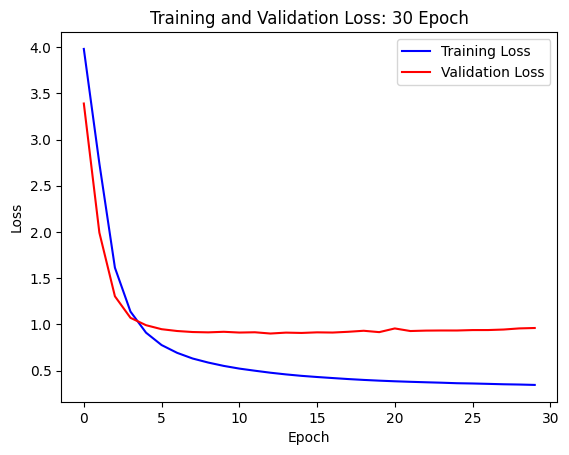

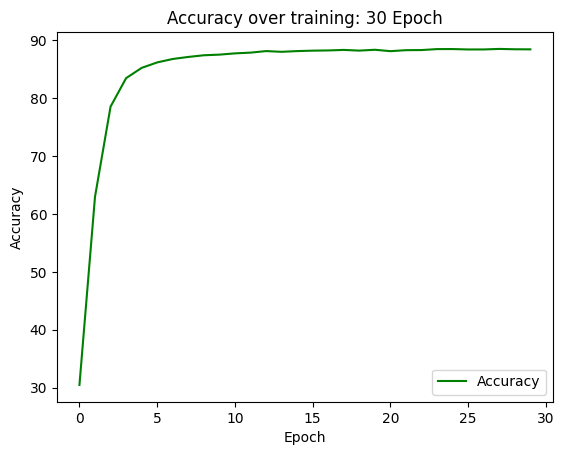

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss, label="Training Loss", color="blue")
plt.plot(range(len(train_loss)), val_loss, label="Validation Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss: 30 Epoch")
plt.legend()
plt.show()


plt.plot(range(len(train_loss)), acc, label="Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over training: 30 Epoch")
plt.legend()
plt.show()

#### Test


In [ ]:
correct = test_sentences[521]
testing = correct[:8]      # autocomplete based on

input_test = [word_to_idx.get(i, word_to_idx['UNK']) for i in testing]
while len(input_test) < 20:
  input_test.append(word_to_idx['EOL'])

print("Original/Correct:", correct)
print("Input:", [idx_to_word[i] for i in input_test])
print("Converted to IDs:", input_test)
output = model(torch.tensor(input_test).to(DEVICE)).squeeze()
print(output.shape)
print("Output: ", torch.argmax(output, dim=1).tolist())
print("Converted to words", [idx_to_word[i] for i in torch.argmax(output, dim=1).tolist()])

Original/Correct: ['i', 'get', 'people', 'asking', 'me', 'what', 'it', 'feels', 'like', 'to', 'be', 'the', 'most', 'hated', 'man', 'in', 'dallas', 'county', 'said', 'assessor']
Input: ['i', 'get', 'people', 'asking', 'me', 'what', 'it', 'feels', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Converted to IDs: [5426, 9436, 12150, 4050, 9011, 3134, 109, 6298, 12085, 12085, 12085, 12085, 12085, 12085, 12085, 12085, 12085, 12085, 12085, 12085]
torch.Size([20, 13587])
Output:  [9436, 12150, 4050, 9011, 3134, 109, 6298, 8136, 12085, 12085, 12085, 12085, 12085, 12085, 12085, 12085, 12085, 12085, 12085, 12085]
Converted to words ['get', 'people', 'asking', 'me', 'what', 'it', 'feels', 'so', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']


In [ ]:
torch.save(model, open("model_transformer8.pt", "wb"))

In [ ]:
def test():
    with tqdm(total=len(test_loader), desc="Testing: ") as test_loop:
        model.eval()
        total_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)

                # Calculate loss
                outputs_flat = outputs.view(-1, outputs.size(2))
                #print(outputs_flat.shape)
                targets_flat = targets.view(-1)
                loss = criterion(outputs_flat, targets_flat)
                total_loss += loss.item()

                # Calculate accuracy
                _, predicted = outputs.max(2)
                #print(predicted)
                mask = targets != word_to_idx['EOL']  # Don't count EOL tokens
                correct += (predicted == targets)[mask].sum().item()
                #print(correct)
                total += mask.sum().item()

                test_loop.update(1)

        test_loss = total_loss / len(test_loader)
        accuracy = 100 * correct / total

    return test_loss, accuracy

test_loss, acc = test()
print("Current Test Loss with Last Word Prediction:", test_loss)
print("Accuracy:", acc, "%")

Testing:   0%|          | 0/32 [00:00<?, ?it/s]

Current Test Loss with Last Word Prediction: 0.7168073877692223
Accuracy: 94.30917427931611 %


According to our results, we observed the best performance after training for 10 epochs. We retrain the model and save all required parameters for 5C.



In [ ]:
import pickle

model = Transformer_8(len(word_to_idx), WORD_VEC_SIZE, 256, embedding).to(DEVICE)
optimizer = torch.optim.Adagrad(
    model.parameters(),
    lr=0.01
)
criterion = nn.CrossEntropyLoss()
train(10, model)

Embedding dim: 296 Hidden dim: 256


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

([3.9517747225761415,
  2.822626741886139,
  1.7284525163173676,
  1.1906295434236527,
  0.9342155746221542,
  0.7913998211622238,
  0.7005307297706604,
  0.6363384687900543,
  0.590804694712162,
  0.5528943052887917],
 [3.349909294219244,
  2.172774449227348,
  1.3749691134407407,
  1.1160081672290014,
  1.002716843097929,
  0.9520942871532743,
  0.9500903799420312,
  0.9180411289608668,
  0.903526937204694,
  0.8921513538511973],
 [30.63375892586855,
  59.54377904802607,
  76.8577381270367,
  82.68247947718005,
  84.99385650942892,
  86.04804387698773,
  86.60540983314635,
  87.11469629787916,
  87.39070819310149,
  87.66850081022847])

In [ ]:
# SAVE
with open('transformers_8_modelprereqs.pickle', 'wb') as handle:
   a = (embedding, word_to_idx)
   pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

torch.save(model, open('transformers_8_weights.pt', 'wb'))

In [ ]:
#LOAD
#e, w = pickle.load(open('transformers_8_modelprereqs.pickle', 'rb'))

model = torch.load(open('transformers_8_weights.pt', 'rb'))
test_loss, acc = test()
print("Testing model after import from file, Loss:", test_loss)
print("Accuracy:", acc, "%")

<ipython-input-19-259498b27221>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(open('transformers_8_weights.pt', 'rb'))


Testing:   0%|          | 0/32 [00:00<?, ?it/s]

Testing model after import from file, Loss: 0.570004500914365
Accuracy: 93.79021078448797 %


## Assignment 5C

#### Problem Statement
1. 	Write a small program that ask you to input a word or part of the sentence.
2.	The program will suggest the rest of the sentence. Then the program will ask for next input.
3.	Your code would be modular in the sense that you can plug in the LSTM model or transformer model anytime.

  Example:
```
i. Input: I play
ii. Output: cricket everyday eol eol eol eol
iii. Input: I live
iv. Output: in Bangladesh eol eol eol eol
```

#### Inference

The following code can be pasted into a .py file and be used for inference.

In [ ]:
import torch
import pickle

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Define device (CPU or GPU)

def load_model(filename_weights, filename_prereqs):
    m = torch.load(open(filename_weights, 'rb'), map_location=DEVICE)
    e, w = pickle.load(open(filename_prereqs, 'rb'))

    return m, e, w

def generate_text(model, initial_text, word_to_idx, max_length=20):
    """
    Generate text using a trained transformer or LSTM model with greedy sampling.

    Args:
        model: Trained model (transformer or LSTM)
        initial_text (str): Starting text prompt
        word_to_idx (dict): Dictionary mapping words to indices
        max_length (int): Maximum length of generated sequence

    Returns:
        str: Generated text including the initial prompt
    """
    # Tokenize initial text
    input_words = initial_text.strip().split()
    input_ids = [word_to_idx[word] for word in input_words]
    cur_len = len(input_ids)
    while len(input_ids) < 20:
        input_ids.append(word_to_idx['EOL'])
    current_ids = torch.tensor([input_ids]).to(DEVICE)

    # Generate idx to word so we can turn model output into human-recognizable sentences
    idx_to_word = {idx:word for word, idx in word_to_idx.items()}

    # Keep track of generated words
    generated_words = input_words.copy()

    # Generate one word at a time
    with torch.no_grad():
        i = cur_len-1
        while i < max_length:
            # Get model predictions
            print("Input:", [idx_to_word[i] for i in current_ids.squeeze().tolist()])
            outputs = model(current_ids)
            #print(torch.argmax(outputs, dim=2).shape)
            print("Output from model:", [idx_to_word[i] for i in torch.argmax(outputs, dim=2).squeeze().tolist()])

            # Problem: output may generate more than one word, and any extra n words must be added to the input or it will fall into a same-word loop
            next_token_logits = outputs[0, i, :]  # Get logits for next token

            def logit_to_word(next_token_logits):
                # Get the most likely next word
                next_token_id = torch.argmax(next_token_logits).unsqueeze(0)

                # Convert to integer and get the word
                next_word_idx = next_token_id.item()
                next_word = idx_to_word[next_word_idx]
                #print("This word!: ", next_word)

                return next_word
                # Add to generated words

            # check if output is EOL (break), or contains a word (then append)
            if logit_to_word(next_token_logits) == 'EOL':
                break
            else:
                while logit_to_word(next_token_logits) != 'EOL':
                    generated_words.append(logit_to_word(next_token_logits))
                    # Add predicted token to sequence
                    # add the word as id
                    next_token_id = torch.tensor(word_to_idx[generated_words[-1]])   # the last thing I added was obviously the word
                    if i+1 == max_length:
                        i+=1   # break out of outer loop
                        break
                    current_ids[:, i+1] = next_token_id.unsqueeze(0)
                    i+=1
                    next_token_logits = outputs[0, i, :]


    # Join the words with spaces
    generated_text = ' '.join(generated_words)
    #print(generated_text)
    return generated_text


def main(*args):
    model_to_use = None

    if args[0] == 'lstm':
        model_to_use = 'lstm'
    else:
        model_to_use = 'transformer'

    print("LSTM/Transformer Next Word Prediction: ")
    print("Enter space seperated words(less than 20): ")

    # load model
    model = None
    embedding = None
    word_to_idx = None
    if model_to_use == 'lstm':
        model, embedding, word_to_idx = load_model('lstm_20_weights.pt', 'lstm_20_modelprereqs.pickle')
    else:
        model, embedding, word_to_idx = load_model('transformers_8_weights.pt', 'transformers_8_modelprereqs.pickle')

    # produce input vector
    inputwords = None
    if args[1] != None:
        inputwords = args[1]
    else:
        inputwords = input()

    print("Output String:", generate_text(model, inputwords, word_to_idx))

# TODO: Try inference on t4 and see whether it improves
# TODO: if model generates more than one word, add both to



In [ ]:
main('transformers', 'i feel so')

LSTM/Transformer Next Word Prediction: 
Enter space seperated words(less than 20): 
Input: ['i', 'feel', 'so', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Output from model: ['feel', 'so', 'i', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Input: ['i', 'feel', 'so', 'i', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Output from model: ['feel', 'so', 'i', 'feel', 'it', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Input: ['i', 'feel', 'so', 'i', 'feel', 'it', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Output from model: ['feel', 'so', 'i', 'feel', 'it', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Output S

<ipython-input-51-961f26184ee4>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m = torch.load(open(filename_weights, 'rb'), map_location=DEVICE)


In [ ]:
main('transformers', 'i get people asking me what it feels')

LSTM/Transformer Next Word Prediction: 
Enter space seperated words(less than 20): 
Input: ['i', 'get', 'people', 'asking', 'me', 'what', 'it', 'feels', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Output from model: ['get', 'people', 'asking', 'me', 'what', 'it', 'feels', 'so', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Input: ['i', 'get', 'people', 'asking', 'me', 'what', 'it', 'feels', 'so', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Output from model: ['get', 'people', 'asking', 'me', 'what', 'it', 'feels', 'so', 'so', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Input: ['i', 'get', 'people', 'asking', 'me', 'what', 'it', 'feels', 'so', 'so', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Output from model: ['get', 'people', 'asking', 'me', 'what', 'it', 'feels', 'so', 'so', 'so', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 

<ipython-input-51-961f26184ee4>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m = torch.load(open(filename_weights, 'rb'), map_location=DEVICE)


In [ ]:
main('lstm', 'i get people asking me what it feels')

LSTM/Transformer Next Word Prediction: 
Enter space seperated words(less than 20): 
Input: ['i', 'get', 'people', 'asking', 'me', 'what', 'it', 'feels', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Output from model: ['feel', 'a', 'to', 'to', 'to', 'i', 'is', 'like', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Input: ['i', 'get', 'people', 'asking', 'me', 'what', 'it', 'feels', 'like', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Output from model: ['feel', 'a', 'to', 'to', 'to', 'i', 'is', 'like', 'i', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Input: ['i', 'get', 'people', 'asking', 'me', 'what', 'it', 'feels', 'like', 'i', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Output from model: ['feel', 'a', 'to', 'to', 'to', 'i', 'is', 'like', 'i', 'am', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']


<ipython-input-51-961f26184ee4>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m = torch.load(open(filename_weights, 'rb'), map_location=DEVICE)


In [ ]:
main('lstm', 'i feel so')

LSTM/Transformer Next Word Prediction: 
Enter space seperated words(less than 20): 
Input: ['i', 'feel', 'so', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Output from model: ['feel', 'like', 'blessed', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Input: ['i', 'feel', 'so', 'blessed', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Output from model: ['feel', 'like', 'blessed', 'to', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Input: ['i', 'feel', 'so', 'blessed', 'to', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL']
Output from model: ['feel', 'like', 'blessed', 'to', 'be', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL', 'EOL

<ipython-input-51-961f26184ee4>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m = torch.load(open(filename_weights, 'rb'), map_location=DEVICE)
